# Object Detection Tutorial

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/georgia-tech-db/eva/blob/master/tutorials/02-object-detection.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run on Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/georgia-tech-db/eva/blob/master/tutorials/02-object-detection.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /> View source on GitHub</a>
  </td>
  <td>
    <a target="_blank" href="https://raw.githubusercontent.com/georgia-tech-db/eva/master/tutorials/02-object-detection.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" /> Download notebook</a>
  </td>
</table>

### Start EVA server

We are reusing the start server notebook for launching the EVA server.

In [1]:
#!wget -nc "https://raw.githubusercontent.com/georgia-tech-db/eva/master/tutorials/00-start-eva-server.ipynb"
%run 00-start-eva-server.ipynb
cursor = connect_to_server()

kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]
rm: nohup.out: No such file or directory
cat: nohup.out: No such file or directory
22/12/06 13:14:41 WARN Utils: Your hostname, Jiachengs-MacBook-Air-2.local resolves to a loopback address: 127.0.0.1; using 10.180.244.77 instead (on interface en0)
22/12/06 13:14:41 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/12/06 13:14:41 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
12-06-2022 13:14:43 WARNING[create_udf_executor:create_udf_executor.py:exec:0042] UDF FastRCNNObjectDetector already exists, nothing added.
12-06-2022 13:14:43 WARNING[create_udf_executor:create_udf_executor.py:exec:00


[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import cv2
import numpy as np
from pprint import pprint
from matplotlib import pyplot as plt
import car_plate_detector
import ocr_extractor
import os
from ipywidgets import Video, Image

/Users/jiachengshang/CS4420/4420Project/test_eva_db/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: dlopen(/Users/jiachengshang/CS4420/4420Project/test_eva_db/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libpng16.16.dylib
  Referenced from: <5F6B6919-410D-397C-98F2-12C5934F9DBE> /Users/jiachengshang/CS4420/4420Project/test_eva_db/lib/python3.9/site-packages/torchvision/image.so
  Reason: tried: '/Users/malfet/miniforge3/envs/py_39_torch-1.10.2/lib/libpng16.16.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/malfet/miniforge3/envs/py_39_torch-1.10.2/lib/libpng16.16.dylib' (no such file), '/Users/malfet/miniforge3/envs/py_39_torch-1.10.2/lib/libpng16.16.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/malfet/miniforge3/envs/py_39_torch-1.10.2/lib/libpng16.16.dylib' (no such file), '/Users/malfet/miniforge3/envs/py_39_torch-1.10.2/lib/libpng16.16.dylib' 

In [3]:
def image_resize(image, width=None, height=None, inter=cv2.INTER_CUBIC):
    # https://stackoverflow.com/questions/44650888/resize-an-image-without-distortion-opencv
    dim = None
    (h, w) = image.shape[:2]

    if width is None and height is None:
        return image

    if width is None:
        r = height / float(h)
        dim = (int(w * r), height)
    else:
        r = width / float(w)
        dim = (width, int(h * r))

    resized = cv2.resize(image, dim, interpolation=inter)

    return resized

def unsharp_mask(image, kernel_size=(5, 5), sigma=1.0, amount=1.0, threshold=0):
    # https://stackoverflow.com/questions/4993082/how-to-sharpen-an-image-in-opencv
    blurred = cv2.GaussianBlur(image, kernel_size, sigma)
    sharpened = float(amount + 1) * image - float(amount) * blurred
    sharpened = np.maximum(sharpened, np.zeros(sharpened.shape))
    sharpened = np.minimum(sharpened, 255 * np.ones(sharpened.shape))
    sharpened = sharpened.round().astype(np.uint8)
    if threshold > 0:
        low_contrast_mask = np.absolute(image - blurred) < threshold
        np.copyto(sharpened, image, where=low_contrast_mask)
    return sharpened

def show_images(images, cols=1, prefix='Image ', titles=None):
    # https://gist.github.com/soply/f3eec2e79c165e39c9d540e916142ae1
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None:
        titles = [f'{prefix} ({i})' for i in range(1, n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, int(np.ceil(n_images/float(cols))), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

def remove_noise(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Morph open to remove noise
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)

    # Find contours and remove small noise
    cnts = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    for c in cnts:
        area = cv2.contourArea(c)
        if area < 200:
            cv2.drawContours(opening, [c], -1, 0, -1)

    # Invert and apply slight Gaussian blur
    result = 255 - opening
    #result = cv2.GaussianBlur(result, (3,3), 0)
    return result

from pprint import pprint
import cv2
import numpy as np
from matplotlib import pyplot as plt

def annotate_video(detections, input_video_path):
    color1=(207, 248, 64)
    color2=(255, 49, 49)
    thickness=4

    vcap = cv2.VideoCapture(input_video_path)
    width = int(vcap.get(3))
    height = int(vcap.get(4))


    frame_id = 0
    # Capture frame-by-frame
    # ret = 1 if the video is captured; frame is the image
    ret, frame = vcap.read()
    car_plates = []

    while ret:
        df = detections
        df = df[['carplatedetector.results']][df.index == frame_id]
        if df.size:
            dfList = df.values.tolist()
            mask = np.array(dfList[0][0])
            mask = mask.astype(np.uint8)
            #plt.imshow(mask)
            #frame = cv2.cvtColor(np.array(frame, copy=True), cv2.COLOR_RGB2BGR)
            contours, hierarchy = cv2.findContours(
                mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            bboxes = []
            j = 0
            for c in contours:
                x,y,w,h = cv2.boundingRect(c)
                if w >= 10 and h >= 10:
                    plate = frame[y:y+h, x:x+w]
                    # resize_height = 256
                    # plate = image_resize(
                    #      plate, height= resize_height)
                    #
                    # sharpen_amount = 50
                    # plate = unsharp_mask(plate, amount=sharpen_amount)
                    # plate = cv2.cvtColor(np.array(plate), cv2.COLOR_BGR2RGB)
                    # #plate = remove_noise(plate)
                    #plate = cv2.fastNlMeansDenoisingColored(plate,None,20,10,7,21)
                    fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
                    fps = 25
                    dim = plate.shape[:2]
                    video = cv2.VideoWriter("frame" + str(frame_id)+ "_plate" + str(j) + ".mp4", fourcc, fps, (dim[1], dim[0]))
                    print(plate.shape)
                    print([x, y, w, h])
                    plate = cv2.cvtColor(plate, cv2.COLOR_RGB2BGR)
                    for _ in range(50): video.write(plate)
                    video.release()
                    """
                    x1, y1, x2, y2 = bbox
                    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
                    # object bbox
                    img=cv2.rectangle(frame, (x1, y1), (x2, y2), color1, thickness) 
                    # object label
                    cv2.putText(img, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 10, color1, thickness) 
                    # frame label
                    cv2.putText(img, 'Frame ID: ' + str(frame_id), (700, 500), cv2.FONT_HERSHEY_SIMPLEX, 1.2, color2, thickness)
                video.write(img)
                    """
                    bbox = [x, y, x + w, y + h]

                    if frame_id % 5 == 0:
                        plt.imshow(plate)
                        plt.show()
                # show_images(plates,  prefix='License plate')
                    bboxes.append(bbox)
                    j += 1
            car_plates.append(bboxes)
        frame_id+=1
        ret, frame = vcap.read()
    return car_plates

def visualize_video(car_plates, labels, input_video_path):
    color1=(207, 248, 64)
    color2=(255, 49, 49)
    thickness = 4

    vcap = cv2.VideoCapture(input_video_path)
    width = int(vcap.get(3))
    height = int(vcap.get(4))
    fps = vcap.get(5)
    fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v') #codec
    file_name = input_video_path.split("/")[-1]
    output_path = os.path.join("result", file_name)
    video=cv2.VideoWriter(output_path, fourcc, fps, (width,height))

    frame_id = 0
    # Capture frame-by-frame
    # ret = 1 if the video is captured; frame is the image
    ret, frame = vcap.read()
    while ret and frame_id < len(car_plates):
            bboxes = car_plates[frame_id]
            for i, bbox in enumerate(bboxes):
                x1, y1, x2, y2 = bbox
                x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)

                # object bbox
                img=cv2.rectangle(frame, (x1, y1), (x2, y2), color1, thickness)
                # object label
                if i < len(labels[frame_id]):
                    cv2.putText(img, labels[frame_id][i].upper(), (x1 - 20, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 1, color1, thickness)
                # frame label
                cv2.putText(img, 'Frame ID: ' + str(frame_id), (700, 500), cv2.FONT_HERSHEY_SIMPLEX, 1.2, color2, thickness)
            for _ in range(50):
                video.write(img)

            frame_id += 1
            ret, frame = vcap.read()
    video.release()
    vcap.release()

### Getting the Video Files

12-06-2022 13:14:52 ERROR [drop_executor:drop_executor.py:exec:0059] Failed to drop TABLE REF:: ( ObjectDetectionVideos SAMPLE FREQUENCY None)
NoneType: None


@status: 0
@batch: Batch Object:
@dataframe:                                                    0
0  Table Successfully dropped: ObjectDetectionVideos
@batch_size: 1
@identifier_column: None
@query_time: 0.023670707999999152
@status: 0
@batch: Batch Object:
@dataframe:                                                   0
0  Video successfully added at location: data/1.mp4
@batch_size: 1
@identifier_column: None
@query_time: 0.02851516700000012
@status: 0
@batch: Batch Object:
@dataframe:                                            0
0  UDF CarPlateDetector successfully dropped
@batch_size: 1
@identifier_column: None
@query_time: 0.0036323329999987664


/Users/jiachengshang/CS4420/4420Project/test_eva_db/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: dlopen(/Users/jiachengshang/CS4420/4420Project/test_eva_db/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libpng16.16.dylib
  Referenced from: <5F6B6919-410D-397C-98F2-12C5934F9DBE> /Users/jiachengshang/CS4420/4420Project/test_eva_db/lib/python3.9/site-packages/torchvision/image.so
  Reason: tried: '/Users/malfet/miniforge3/envs/py_39_torch-1.10.2/lib/libpng16.16.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/malfet/miniforge3/envs/py_39_torch-1.10.2/lib/libpng16.16.dylib' (no such file), '/Users/malfet/miniforge3/envs/py_39_torch-1.10.2/lib/libpng16.16.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/malfet/miniforge3/envs/py_39_torch-1.10.2/lib/libpng16.16.dylib' (no such file), '/Users/malfet/miniforge3/envs/py_39_torch-1.10.2/lib/libpng16.16.dylib' 

@status: 0
@batch: Batch Object:
@dataframe:                                                    0
0  UDF CarPlateDetector successfully added to the...
@batch_size: 1
@identifier_column: None
@query_time: 1.6966915829999998
@status: 0
@batch: Batch Object:
@dataframe:    objectdetectionvideos.id                           carplatedetector.results
0                         0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
@batch_size: 1
@identifier_column: None
@query_time: 398.858034917
(50, 90, 3)
[258, 859, 90, 50]


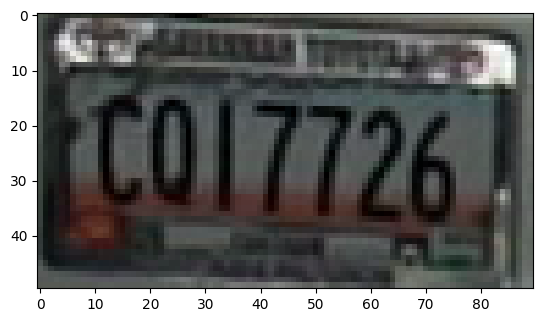

(50, 92, 3)
[2101, 598, 92, 50]


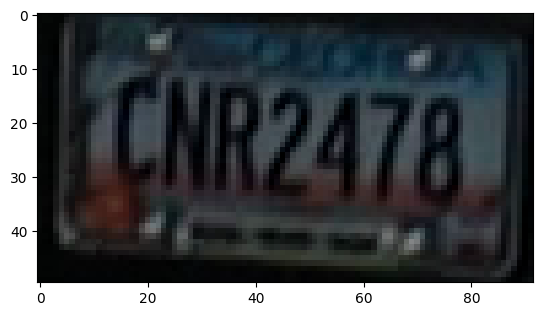

(49, 84, 3)
[930, 404, 84, 49]


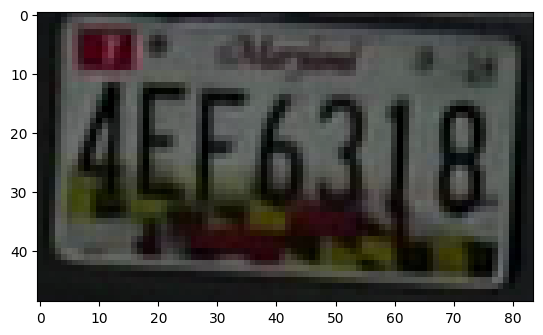

(39, 76, 3)
[3752, 32, 76, 39]


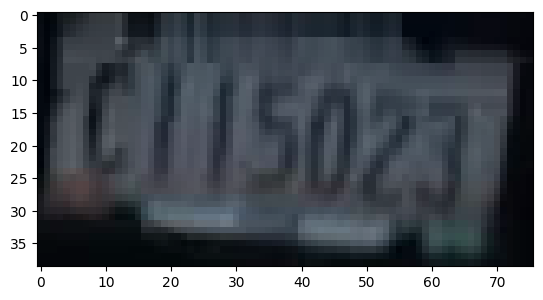

@status: 0
@batch: Batch Object:
@dataframe:                                        0
0  UDF OCRExtractor successfully dropped
@batch_size: 1
@identifier_column: None
@query_time: 0.025378292000027614


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


@status: 0
@batch: Batch Object:
@dataframe:                                                    0
0  UDF OCRExtractor successfully added to the dat...
@batch_size: 1
@identifier_column: None
@query_time: 4.2010037919999945


12-06-2022 13:21:39 ERROR [drop_executor:drop_executor.py:exec:0059] Failed to drop TABLE REF:: ( ObjectDetectionVideos SAMPLE FREQUENCY None)
NoneType: None
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
12-06-2022 13:21:44 ERROR [drop_executor:drop_executor.py:exec:0059] Failed to drop TABLE REF:: ( ObjectDetectionVideos SAMPLE FREQUENCY None)
NoneType: None
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
12-06-2022 13:21:46 ERROR [drop_executor:drop_executor.py:exec:0059] Failed to drop TABLE REF:: ( ObjectDetectionVideos SAMPLE FREQUENCY None)
NoneType: None
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
12-06-2022 13:21:49 ERROR [drop_executor:drop_executor.py:exec:0059] Failed to drop TABLE REF:: ( ObjectDetectionVideos SAMPLE FREQUENCY None)
NoneType: None
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


[['[c017726]', 'C4R247e ', 'reF6318]', '1502]']]


12-06-2022 13:21:54 ERROR [drop_executor:drop_executor.py:exec:0059] Failed to drop TABLE REF:: ( ObjectDetectionVideos SAMPLE FREQUENCY None)
NoneType: None


@status: 0
@batch: Batch Object:
@dataframe:                                                    0
0  Table Successfully dropped: ObjectDetectionVideos
@batch_size: 1
@identifier_column: None
@query_time: 0.017971208000005845
@status: 0
@batch: Batch Object:
@dataframe:                                                    0
0  Video successfully added at location: data/.DS...
@batch_size: 1
@identifier_column: None
@query_time: 0.021529167000039706
@status: 0
@batch: Batch Object:
@dataframe:                                            0
0  UDF CarPlateDetector successfully dropped
@batch_size: 1
@identifier_column: None
@query_time: 0.0027934170000207814
@status: 0
@batch: Batch Object:
@dataframe:                                                    0
0  UDF CarPlateDetector successfully added to the...
@batch_size: 1
@identifier_column: None
@query_time: 1.2033979999999929


OpenCV: Couldn't read video stream from file "/Users/jiachengshang/.eva/eva_datasets/87c183b26a2ea6c4a1475bdbdc96ea43/.DS_Store"
[ERROR:0] global /private/var/folders/b7/g6qfbypj0tq32j5_trjh516r0000gn/T/pip-req-build-95s9ftaq/opencv/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.5.4) /private/var/folders/b7/g6qfbypj0tq32j5_trjh516r0000gn/T/pip-req-build-95s9ftaq/opencv/modules/videoio/src/cap_images.cpp:253: error: (-5:Bad argument) CAP_IMAGES: can't find starting number (in the name of file): /Users/jiachengshang/.eva/eva_datasets/87c183b26a2ea6c4a1475bdbdc96ea43/.DS_Store in function 'icvExtractPattern'


OpenCV: Couldn't read video stream from file "data/.DS_Store"
[ERROR:0] global /private/var/folders/b7/g6qfbypj0tq32j5_trjh516r0000gn/T/pip-req-build-95s9ftaq/opencv/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.5.4) /private/var/folders/b7/g6qfbypj0tq32j5_trjh516r0000gn/T/pip-req-build-95

@status: 0
@batch: Batch Object:
@dataframe: Empty DataFrame
Columns: []
Index: []
@batch_size: 0
@identifier_column: None
@query_time: 0.9412077910000107
@status: 0
@batch: Batch Object:
@dataframe:                                        0
0  UDF OCRExtractor successfully dropped
@batch_size: 1
@identifier_column: None
@query_time: 0.002591833999986193
@status: 0
@batch: Batch Object:
@dataframe:                                                    0
0  UDF OCRExtractor successfully added to the dat...
@batch_size: 1
@identifier_column: None
@query_time: 2.2928382910000096
[]


OpenCV: Couldn't read video stream from file "data/.DS_Store"
[ERROR:0] global /private/var/folders/b7/g6qfbypj0tq32j5_trjh516r0000gn/T/pip-req-build-95s9ftaq/opencv/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.5.4) /private/var/folders/b7/g6qfbypj0tq32j5_trjh516r0000gn/T/pip-req-build-95s9ftaq/opencv/modules/videoio/src/cap_images.cpp:253: error: (-5:Bad argument) CAP_IMAGES: can't find starting number (in the name of file): data/.DS_Store in function 'icvExtractPattern'


[ERROR:0] global /private/var/folders/b7/g6qfbypj0tq32j5_trjh516r0000gn/T/pip-req-build-95s9ftaq/opencv/modules/videoio/src/cap.cpp (597) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.5.4) /private/var/folders/b7/g6qfbypj0tq32j5_trjh516r0000gn/T/pip-req-build-95s9ftaq/opencv/modules/videoio/src/cap_images.cpp:253: error: (-5:Bad argument) CAP_IMAGES: can't find starting number (in the name of file): result/.DS_Store in function 'icvExtractPattern'




In [4]:
directory = "data"
for filename in os.listdir(directory):
    video_path = os.path.join(directory, filename)
    cursor.execute('DROP TABLE ObjectDetectionVideos')
    response = cursor.fetch_all()
    print(response)
    cmd = 'LOAD FILE "' + video_path + '" INTO ObjectDetectionVideos;'
    cursor.execute(cmd) 
    response = cursor.fetch_all()
    print(response)

    #Video.from_file(video_path, embed=True)
    
    # drop car plate detector udf
    cursor.execute("DROP UDF CarPlateDetector;")
    response = cursor.fetch_all()
    print(response)

    cursor.execute("""CREATE UDF IF NOT EXISTS CarPlateDetector
      INPUT  (frame NDARRAY UINT8(3, ANYDIM, ANYDIM))
      OUTPUT (results NDARRAY FLOAT32(ANYDIM, ANYDIM))
      TYPE  Classification
      IMPL  'car_plate_detector.py';
      """) # for other machines delete "tutorials/"
    response = cursor.fetch_all()
    print(response)  
    
    cursor.execute("""SELECT id, CarPlateDetector(data)
                  FROM ObjectDetectionVideos 
                  WHERE id < 1""")
    response = cursor.fetch_all()
    print(response)

    dataframe = response.batch.frames
    car_plates = annotate_video(dataframe, video_path)

    cursor.execute("DROP UDF OCRExtractor;")
    response = cursor.fetch_all()
    print(response)

    cursor.execute("""CREATE UDF IF NOT EXISTS OCRExtractor
          INPUT  (frame NDARRAY UINT8(3, ANYDIM, ANYDIM))
          OUTPUT (labels NDARRAY STR(ANYDIM), bboxes NDARRAY FLOAT32(ANYDIM, 4),
                    scores NDARRAY FLOAT32(ANYDIM))
          TYPE  Classification
          IMPL  'ocr_extractor.py';
          """)
    response = cursor.fetch_all()
    print(response)

    labels = []
    for i, plates in enumerate(car_plates):
        plate_numbers = []
        for j, _ in enumerate(plates):
            file_name = "frame" + str(i)+ "_plate" + str(j) + ".mp4"
            cursor.execute('DROP TABLE ObjectDetectionVideos')
            response = cursor.fetch_all()
            #print(response)
            cursor.execute('LOAD FILE "' + file_name + '" INTO ObjectDetectionVideos;')
            response = cursor.fetch_all()
            #print(response)
            cursor.execute("""SELECT id, OCRExtractor(data)
                          FROM ObjectDetectionVideos
                          WHERE id < 1""")
            response = cursor.fetch_all()
            #print(response)
            df = response.batch.frames
            df = df[['ocrextractor.labels']][df.index == 0]
            if df.size:
                dfList = df.values.tolist()
                if len(dfList[0][0]) > 0:
                  st = ""
                  for item in dfList[0][0]:
                    st += item
                    st += ", "
                  st = st[:len(st)-2]
                  plate_numbers.append(st)
                else: plate_numbers.append(" ")
            else: plate_numbers.append(" ")
        labels.append(plate_numbers)
    print(labels)

    dataframe = response.batch.frames
    visualize_video(car_plates, labels, video_path)



In [5]:
print(car_plates)


[]


### Load the surveillance videos for analysis